In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

import numpy as np
from scipy import stats

mpl.rcParams.update({
    'font.size'           : 24.0,
    'axes.titlesize'      : 'large',
    'axes.labelsize'      : 'medium',
    'xtick.labelsize'     : 'medium',
    'ytick.labelsize'     : 'medium',
    'legend.fontsize'     : 'large',
})


# Parameter Estimation & Sampling

### Morning: Estimating distribution parameters
- Review: moments of distributions
- Why estimate distributions?
- Method Of Moments (MOM)
- Maximum Likelihood Estimation (MLE)
- Maximum A Posteriori Estimation (MAP)
- Kernel Density Estimation (KDE)

### Afternoon: Sampling
- Population inference
- Central Limit Theorem (CLT)
- Confidence Intervals
- Bootstrapping

# Review: Moments of a Distribution

On probability day, we explored the following question: "Given a probability distribution for a random variable, what are the properties of data generated by the distribution?" Our tool was the expectation value.

### Mean: $\mu = \text{E}[X]$

#### Discrete random variable: $\text{E}[X] = \sum\limits_{x \in S} x \text{P}(X=x)$

#### Continuous random variable: $\text{E}[X] = \int_{-\infty}^{\infty} x f(x) \,dx$

#### Helpful Properties:
 - scalar multiplication: $\text{E}[cX] = c\text{E}[x]$
 - addition: $\text{E}[X + Y] = \text{E}[X] + \text{E}[Y]$
 - expectation of a constant: $\text{E}[c] = c$

### Variance $\sigma^2 = \text{Var}(X) = \text{E}[(X - \text{E}[X])^2]$

#### Discrete: $\sigma^2 = \sum\limits_{x \in S} (x-\mu)^2 \text{P}(X=x)$

#### Continuous: $\sigma^2 = \int_{-\infty}^{\infty} (x-\mu)^2 f(x) \,dx$

#### Helpful Properties:
 - scalar multiplication: $\text{Var}(cX) = c^2\text{Var}(X)$
 - addition: $\text{Var}(X + Y) = \text{Var}(X) + \text{Var}(Y) + 2\text{Cov}(X,Y)$
 - variance of a constant: $\text{Var}(c) = 0$
 - $\text{Var}(X) = \text{E}[X^2] - (\text{E}[X])^2 $ (see appendix for proof)
  - $\text{E}[X^2] = \text{Var}(X) + (\text{E}[X])^2 = \sigma^2 + \mu^2  $

### In general, we can calculate expected values of arbitrary powers of X

#### nth raw moment: $\mu_n = E[X^n]$

#### nth central moment: $\mu'_n = E[(X - E[X])^n]$

# Estimating distributions

Today, we have the reverse question: "Given a set of observed data, what are the properties of the probability distribution function that generated it?"

### Why?
- Example 1: You have data on how many people order cakes every day at your bakery, and you want to estimate the probability of selling out.
- Example 2: You have data on how often your car breaks down, and you want to know your chances of safely crossing the country in it.
- Example 3: You have data on how many people visit your website each day, and you want to know the probability of your servers being overloaded.


### How?
- Method of moments (MOM)
- Maximum likelihood estimation (MLE)
- Maximum a posteriori (MAP)
- Non-parametric distribution estimation (KDE)

## Method of Moments

#### Use the sample moments to estimate the moments of the distribution.

- Assume an underlying distribution for your domain.
  - E.g. Poisson, Bernoulli, Binomial, Gaussian
- Compute the relevant moments of your sample.
  - E.g. Mean, Variance
- Derive the formula for your parameters of interest in terms of moments of the PMF/PDF of your assumed distribution

- Substitute the sample moments into the formula, and ta-da!

### Sample: $ \{x_1, x_2, x_3, \ldots, x_n\} $ 
$n$ independent, identically distributed (_iid_) random variables

### Sample mean
$\bar{x} = \frac{1}{n}\sum\limits_{i=1}^n x_i$

### Sample variance
$ s_n^2 = \frac{1}{n}\sum\limits_{i=1}^n (x_i - \bar{x})^2 $

### How good are the sample moments at estimating the population moments?

- sample statistics like $\bar{x}$ and $s_n^2$ are themselves random variables, since they are functions of a collection of random variables $\{x_i\}$
- we can take _expectation values_ of these sample statistics and compare them to the true population statistics.

#### sample mean
$\text{E}[\bar{x}] = \text{E}\left[\frac{1}{n}\sum\limits_{i=1}^n x_i\right] 
    = \frac{1}{n}\sum\limits_{i=1}^n \text{E}[x_i]
    = \frac{1}{n}\sum\limits_{i=1}^n \mu
    = \frac{1}{n}n \mu
    = \mu$
    
- the sample mean $\bar{x}$ is an _unbiased estimator_ of the population mean $\mu$. 

#### sample variance
Exercise: show that
$\text{E}[s_n^2] = \frac{n-1}{n}\sigma^2$
- the sampe variance is a _biased estimator_ of the population variance. This is why you often see [Bessel's Correction](https://en.wikipedia.org/wiki/Bessel%27s_correction) to the sample variance:
$ s_{n-1}^2 = \frac{n}{n-1}s_n^2 = \frac{1}{n-1}\sum\limits_{i=1}^n (x_i - \bar{x})^2 $

This corrected version is the unbiased estimator of population variance. $\text{E}[s_{n-1}^2] = \sigma^2$

### Example 1
- Your website visitor log shows the following number of visits for each of the last seven days: [6, 4, 7, 4, 9, 3, 5]. What’s the probability of zero visitors tomorrow?

#### Which underlying distribution should we assume? What are its parameters?
#### Which moment should we estimate?

In [2]:
visit_data = np.array([6, 4, 7, 4, 9, 3, 5])

In [3]:
xbar = np.mean(visit_data)
s_var = np.var(visit_data)

print("Sample mean: {:.3} \nSample variance: {:.3}".format(xbar, s_var))

Sample mean: 5.43 
Sample variance: 3.67


Poisson! lambda

.

.

.

Poisson: $\text{E}[X] = \lambda$

$\hat{\lambda}_{MOM} = \bar{x}$

In [4]:
dist = stats.poisson(xbar)

print("Poisson(mu): P(X=0)={:.3}".format(dist.pmf(0)))

Poisson(mu): P(X=0)=0.00439


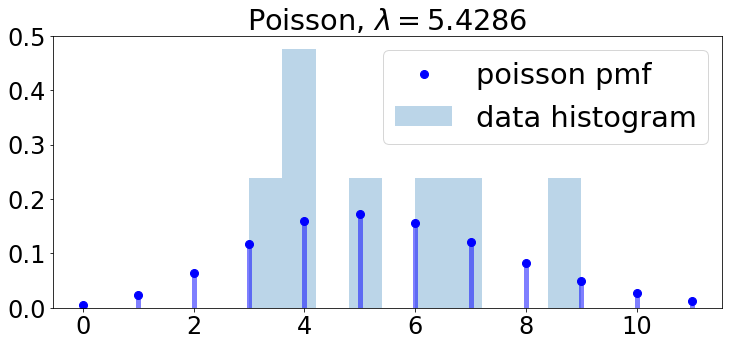

In [6]:
x = np.arange(dist.ppf(0.00001),
              dist.ppf(0.99))

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(x, dist.pmf(x), 'bo', ms=8, label='poisson pmf')
ax.vlines(x, 0, dist.pmf(x), colors='b', lw=5, alpha=0.5)
ax.set_title("Poisson, $\lambda={:.4f}$".format(xbar));
ax.hist(visit_data, normed=True, alpha=0.3, label='data histogram')
ax.legend();

### Example 2
You flip a coin 100 times. It comes up heads 52 times. What’s the MOM estimate that in the next 100 flips the coin will be heads <= 45 times?

#### Which underlying distribution should we assume? What are its parameters?
#### Which moment should we estimate?

Note that this is a single binomial trial, so our data set is just $\{52\}$

$\bar{x} = 52$

$\mu = np$

$\mu = \bar{x} \rightarrow \hat{p}_{MOM} = \frac{\bar{x}}{n} $

In [7]:
n = 100
p = 52/n
dist = stats.binom(n, p)
print(dist.cdf(45))

0.0966533503278


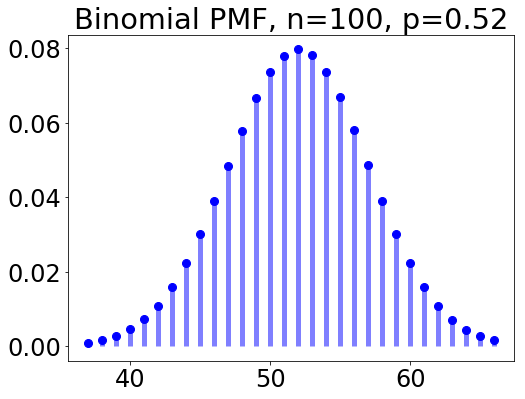

In [8]:
x = np.arange(dist.ppf(0.001),
              dist.ppf(0.999))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(x, dist.pmf(x), 'bo', ms=8, label='binom pmf')
ax.vlines(x, 0, dist.pmf(x), colors='b', lw=5, alpha=0.5)
ax.set_title("Binomial PMF, n=100, p=0.52");

### Example 3

In [16]:
uniform_dist = stats.uniform(0,50)
data = uniform_dist.rvs(10, random_state=10)
print(data)

[ 38.56603216   1.03759747  31.68241175  37.44019413  24.92535062
  11.23983228   9.90314324  38.02653561   8.45554183   4.41699071]


If we assume that the above data are drawn from a continuous uniform distribution $U(0,b)$, what is the MOM estimate of b?

$\mu = \frac{b}{2}$

.

.

.

.

$b = 2\mu$

$\hat{b} = 2\bar{x}$

In [17]:
xbar = np.mean(data)
2*xbar

41.138725956196012

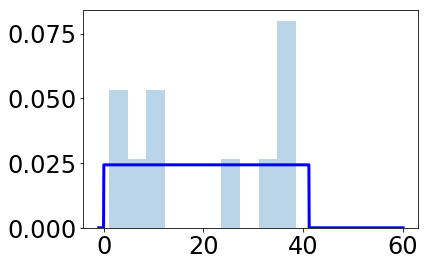

In [18]:
unif = stats.uniform(0,2*xbar)

plt.hist(data, normed=True, alpha=0.3)
x = np.linspace(-1,60, 1000)
plt.plot(x, unif.pdf(x), 'b', linewidth=3);

#### What if we assumed a normal distribution instead?

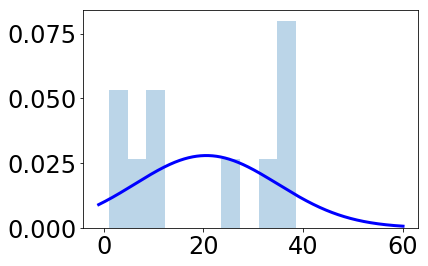

In [19]:
normal = stats.norm(np.mean(data), np.std(data))

plt.hist(data, normed=True, alpha=0.3)
x = np.linspace(-1,60, 1000)
plt.plot(x, normal.pdf(x), 'b', linewidth=3);

See the [KS-test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test), ([scipy docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html)) for more about evaluating the fit of an assumed distribution to observed data.

## Maximum Likelihood Estimation

Say we have some observations $X$ and two hypothetical distributions, $H_1$ and $H_2$:
- Law of Likelihood:
 - If $\text{P}(X| H_1) > \text{P}(X \mid H_2)$, then we say the evidence supports $H_1$ over $H_2$.
- Now imagine we have a whole family of hypothetical distributions, all specified by some set of parameters $\theta$
- Then the hypothesis most supported by the data is set of parameter values $\theta^*$ that maximizes $\text{P}(X| \theta^*)$, which is found via MLE.

### MLE Steps:
- Assume an underlying distribution for your domain. (just like with MOM)
 - E.g. Poisson, Bernoulli, Binomial, Gaussian
- Define the likelihood function.
- We want to know the likelihood of the data we observe under different distribution parameterizations.
- Choose the parameter set that maximizes the likelihood function.

### Defining the likelihood
Say we have a set of observations $\{x_1, x_2, \dots, x_n\}$

We assume some distribution and call its parameters $\theta$, so we write the probability density (or mass) function as $f(x;\theta)$

If $f(x;\theta)$ is a probability mass function, and each data point is _independent and identically distributed_ (i.i.d) according to it, then the probability of observing our entire data set is the product of the probabilities of observing each data point
$$f(x_1, x_2, \dots, x_n | \theta) = f(x_1|\theta) f(x_2|\theta) \dots f(x_n|\theta)$$

(If the distribution is continuous, then this really represents a joint probability density instead of a joint probability. Our estimation process remains the same, however).

#### Likelihood function:
$\mathcal{L}(\theta ; x_1, x_2, \dots, x_n) = f(x_1, x_2, \dots, x_n | \theta) = \prod\limits_{i=1}^n f(x_i | \theta)$

We now want to find the value of $\theta$ that maximizes the likelihood function.

For computational ease (that is, to prevent underflow), we often first take the log of the likelihood, then find the $\theta$ that maximizes that. 

$\hat{\theta}_{\text{mle}} = \arg\max_{\theta \in \Theta} \, \text{log}\left( \mathcal{L}(\theta | x_1, \dots, x_n) \right)$

### Example: Binomial

You flip a coin 100 times. It comes up heads 52 times. What’s the MLE estimate that in the next 100 flips the coin will be heads <= 45 times?

$$ 
\begin{align}
X_i \overset{iid}{\sim} \text{Bin}(n,p) \\
i = 1,2,\ldots,n \\
f(x_i \mid p) &= \binom{n}{x_i}p^{x_i} (1 - p)^{n - x_i} \\
\mathcal{L}(p) &= \prod\limits_{i=1}^n f(x_i \mid p) \\
\log{\mathcal{L}(p)} &= \sum\limits_{i=1}^n\left[\log\binom{n}{x_i} 
    + x_i\log p + (n - x_i)\log(1-p)\right] \\
\frac{\partial \log\mathcal{L}(p)}{\partial p} &= \sum\limits_{i=1}^n\left[ \frac{x_i}{p}
    - \frac{n - x_i}{1-p}\right] = 0 \\
\hat{p}_{MLE} &= \frac{\bar{x}}{n}
\end{align}
$$

### Example: Uniform(0, b)
$0 \leq X \leq b$

Given a set of observations $\{x_1, x_2, \dots, x_n\}$, what is the MLE estimate of b?

.

.


.

$$\text{Likelihood for a single point: }f(x_i\mid b) = \begin{cases}
    \frac{1}{b} & 0 \leq x_i \leq b \\
    0 & x_i\lt 0\text{ or } x_i\gt b
\end{cases}$$

.

.

.



$$ \text{Likelihood for the whole data set}: \\
\mathcal{L}(b;\{x_i\}) = \prod\limits_i^n f(x_i \mid b) = \begin{cases}
    \frac{1}{b^n} & b \geq \text{MAX}(\{x_i\}) \\
    0 & b \lt \text{MAX}(\{x_i\})
\end{cases}
$$

$\hat{b}_{MLE} = \text{MAX}(\{x_i\})$

## Maximum A Posteriori estimation (MAP)

MLE finds $\theta$ that maximizes
$$f(x_1, x_2, \dots, x_n | \theta)$$

But we really want to know this:
$$f(\theta | x_1, x_2, \dots, x_n)$$

That is, we want the probability of a parameter given the data.

We can construct a formula for this using Bayes' Theorem

$$f(\theta | x) = \frac{ f(x|\theta) g(\theta) }{ \int_{\theta' \in \Theta} f(x|\theta') g(\theta') \,d\theta' } \propto f(x|\theta) g(\theta)$$


So now we maximize this:
$$\hat{\theta}_{\text{map}} = \arg\max_{\theta \in \Theta} \, f(x_1, x_2, \dots, x_n | \theta) g(\theta)$$

## Non-parametric methods: Kernel Density Estimation

see companion slides

# Afternoon

### CLT example: website revenue per visitor (see companion slides)

We have a website with ads and a product. Most users (90%) don't generate revenue. Some click ads (7% do, generating a little revenue) and some (3%) buy our app!

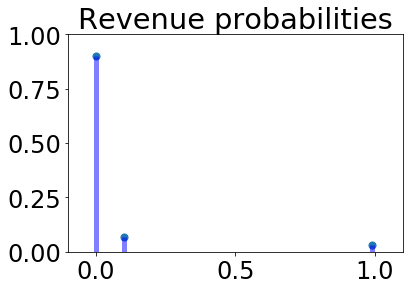

In [36]:
revenues = [0, 0.1, 0.99]
price_probs = [0.9, 0.07, 0.03]

plt.scatter(revenues, price_probs, s=50)
plt.vlines(revenues, 0, price_probs, colors='b', lw=5, alpha=0.5)
plt.axis([-0.1,1.1,0,1])
plt.title('Revenue probabilities');

In [48]:
n=100
print(np.random.choice(revenues, p=price_probs, size=n))

[ 0.    0.    0.    0.    0.    0.1   0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.99  0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.99  0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.1   0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]


In [49]:
def generate_sample_means(sample_size, num_trials):
    means = np.empty(shape=num_trials)
    for i in range(num_trials):
        mean = np.mean(np.random.choice(revenues, p=price_probs, size=n))
        means[i] = mean
    return means

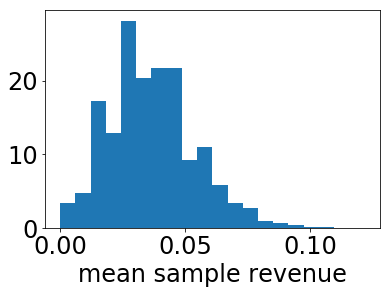

In [51]:
means = generate_sample_means(sample_size=160, num_trials=50000)
plt.hist(means, bins=20, normed=True)
plt.xlabel('mean sample revenue');

### Start to a proof: 
let X be a random variable with an arbitrary distribution, and $\{X_1, X_2, X_3, \cdots, X_n\}$ be a sample of size $n$. Each data point can be considered an independent draw from the same distribution.

Now let Z be the average of those random variables: $Z = \frac{1}{n}\sum_i^n X_i$

$$E[Z] = E\left[\frac{1}{n}\sum_i^n X_i\right] = \frac{1}{n}\sum_i^n E[X_i] = \frac{1}{n} n E[X] = E[X]$$
$$Var[Z] = Var\left[\frac{1}{n}\sum_i^n X_i\right] = \frac{1}{n^2}\sum_i^n Var[X_i] = \frac{1}{n^2} n Var[X] = \frac{1}{n}Var[X]$$